# SpeakEasy, the AI Bartender

*Scott Butters*

You sidle up to the bar at a schnazzy speakeasy downtown and the bartender asks you what you're feeling like. "Oooh, I don't know..." you say, "can you give me something that's like a margarita, but…spicy? Oh, and smoky, but not too sweet."

"I know just the thing," the bartender says. He gets to work grabbing one bottle after another of things you've never heard of before, and a moment later you've got a bit of magic in your mouth, somehow exactly what you'd just asked for. 

That kind of bartender is a special find, a true mixologist. But can we get that kind of thing in the comfort of our own home? Introducing:

## The Natural Language Purveyor of Cocktails

SpeakEasy is an app that integrates knowledge about cocktails and their ingredients with a natural language understanding of English to suggest and invent (coming soon!) cocktail recipes in response to plain English requests. The result is served up as a flask app hosted on Heroku.

While the front-end will be simple to interact with, the system will house three major components under the hood:

* An engine for tokenizing plain-text descriptions of cocktails into a machine interpretable design matrix
* A separate system for parsing cocktail recipes into a desciptive design matrix.
* A model trained to transform a description-space input to a cocktail space output


# Obtain the Data

*Describe your data sources here and explain why they are relevant to the problem you are trying to solve.*

*Your code should download the data and save it in data/raw. If you've got the data from an offline source, describe where it came from and what the files look like. Don't do anything to the raw data files just yet; that comes in the next step.*

*After completing this step, be sure to edit `references/data_dictionary` to include descriptions of where you obtained your data and what information it contains.*

In [12]:
## %%writefile ../src/data/make_dataset.py

# Imports
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests
import json


# Parameters
drizly_drinks_path = '../data/raw/drizly_drinks.pickle'
difford_drink_path = '../data/raw/difford_drink_list.pkl'


def get_soup(url):
    """
    Given url, return soup. Return None if host unresponsive
    """
    soup = None
    r = requests.get(url, timeout=5)
    if r.ok:
        soup = BeautifulSoup(r.content, 'html.parser')
    return soup


def parse_tables(soup):
    df0, df1 = pd.read_html(soup.prettify())
    cocktail = {
        'glass': df0.iloc[0, 0],
        'recipe': df0.iloc[1:, :].rename(columns={0: 'Qty', 1: 'Units', 2: 'Ingredient'}),
        'ingredients': {k: '' for k in df0.iloc[1:, 2]}
    }

    for i, row in df1.iterrows():
        if i % 2:
            continue
        try:
            next_value = df1.iloc[i + 1, 0]
        except:
            next_value = np.nan
        if 'How to make' in row[0]:
            cocktail.update({'instructions': next_value})
        elif 'Garnish' in row[0]:
            cocktail.update({'garnish': next_value})
        elif 'Comment' in row[0]:
            cocktail.update({'description': next_value})
        elif 'Nutrition' in row[0]:
            cocktail.update({'nutrition': next_value})
        elif 'Variant' in row[0]:
            cocktail.update({'variant': next_value})
        elif 'About' in row[0]:
            cocktail.update({'about': next_value})
        else:
            cocktail.update({'other': next_value})
    return cocktail


def get_difford_cocktail_data():
    """
    """
    drink_list = load_from(difford_drink_path)
    num_drinks = len(drink_list)
    failures = 0
    for drink, stats in drink_list.items():
#         print(f'Getting {drink}.', '\r', end='')
        
        num_drinks -= 1
        f = [drink, 'description', 'ingredients', 'name', 'garnish', 'about', 
             'img', 'recipe']
        if len(set(f) & set(stats.keys())) >= len(f) - 3:
            print(f'Drinks remaining: {num_drinks}. Skipped {drink}.', 
                  '\r', end='')
            continue
        try:
            soup = get_soup(stats['url'])
        except:
            failures += 1
            print(f'Failed to get {drink} soup.')
            continue

        # Duplicate name in dict
        stats.update({'name': drink})
        
        # Get ingredient names and links
        ingredients = soup.findAll('table')[0]
        for row in ingredients.findAll('tr'):
            for cell in row.findAll('td'):
                link = cell.find('a')
                if link:
                    name = link.text.replace('\n', '').replace('\xa0', ' ').strip()
                    slug = link['href']
                    url = f'https://www.diffordsguide.com{slug}'
                    stats.update({'ingredients': {'url': url}})
        
        # Get image source
        img_class = 'cocktails_image_wrapper'
        image = soup.find('div', class_=img_class)
        try:
            stats.update({'img': image.img['src']})
        except:
            stats.update({'img': np.nan})
        
        # Parse tables
        tables = parse_tables(soup)
        stats.update({k: v for k, v in tables.items()})
        
        print(f'Drinks remaining: {num_drinks}. Got a {drink}.', '\r', end='')
        save_to(drink_list, difford_drink_path, verbose=False)
    return drink_list


def get_drinks_from_page(soup, drink_list):
    tag = 'div'
    tag_class = 'box-link'
    tags = soup.findAll(tag, attrs={'class': tag_class})
#     print(f'Found {len(tags)} drinks.')
    for div in tags:
        l = div.find('a')
        if l:
            t = div.find('h3')
            name = t.text.replace('\n', '').replace('\xa0', ' ').strip()
            slug = l['href']
            url = f'https://www.diffordsguide.com{slug}'
            drink_list[name] = {'url': url}
    return drink_list


def get_next_page(page=1):
    offset = 40 * (page - 1)
    url = 'https://www.diffordsguide.com/cocktails/search?' \
        '&rating=3%2C3.5%2C4%2C4.5%2C5%2C5.5&sort=name&limit=40' \
        f'&offset={offset}'
    soup = get_soup(url)
    try:
        res = soup.find('div', 
                        attrs={'class': 'global_search_info hairline_bottom'})
        return soup
    except:
        return ''

    
@load_or_make(difford_drink_path, overwrite='n')
def get_cocktail_list():
    drink_list = {}
    page = 1
    soup = get_next_page(page)
    while soup:
        drink_list = get_drinks_from_page(soup, drink_list)
        print(f'Scraped page {page}. Now have {len(drink_list)} drinks.',
             '\r', end='')
        page += 1
        if page > 115:
            break
        soup = get_next_page(page)
    save_to(drink_list, difford_drink_path)
    return drink_list


def get_difford_cocktails():
    get_cocktail_list()
    drink_list = get_difford_cocktail_data()
    return drink_list


def get_ingredients(soup):
    """
    """
    d = soup.find_all('div', attrs={'data-integration-name':'react-component'})
    info = json.loads(d[1].get('data-payload'))
    productIds = info['props']['productIDs']

    base = 'https://drizly.com/async_catalog_fetch?category_overrides'
    ids = '&product_ids[]='.join(map(str, productIds))
    req = f'{base}&product_ids[]={ids}&product_overrides'
    r = requests.get(req)
    if not r.ok:
        return {}
    products = r.json()
    
    ingr_path = '../data/raw/ingredients.pickle'
    if file_exists(ingr_path):
        ingredients = load_from(ingr_path)
    else:
        ingredients = {}
    drink_ingrs = {}
        
    for p in products['catalogItems']:
        name = p['name']
        attrs = {
            'description': p['description'],
            'url': f"https://drizly.com/{p['click_url']}", 
            'categories': p['category_names']}
        ingredients.setdefault(name, {})
        ingredients[name].update(attrs)
        drink_ingrs[name] = attrs
    save_to(ingredients, ingr_path)
    return drink_ingrs


def scrape_text(soup, stats, field, tag, tag_class):
    tags = soup.findAll(tag, attrs={'class': tag_class})
    cleaned = lambda t: t.text.replace('\n', '').replace('\xa0', ' ').strip()
    text = [cleaned(t) for t in tags]
    stats.update({field: text})
    return
        

def get_cocktail_data():
    """
    """
    drink_list = load_from(drizly_drinks_path)
    num_drinks = len(drink_list)
    failures = 0
    for drink, stats in drink_list.items():
        num_drinks -= 1
        f = ['description', 'recipeIngredient', 'name', 'recipeInstructions']
        if len(set(f) & set(stats.keys())) == len(f):
            continue
        try:
            soup = get_soup(stats['url'])
        except:
            failures += 1
            continue

        # Get fields
        data = json.loads(soup.find('script', type='application/ld+json').text)
        stats.update({key: data[key] for key in f})
        
        items = [
            ('tags', 'li', 'Recipe__tag'),
            ('stats', 'li', 'stat'),
            ('tools', 'li', 'Tools__tool')
        ]
        
        # Get items
        for item in items:
            scrape_text(soup, stats, *item)
            
        # Get ingredient data
        drink_ingrs = get_ingredients(soup)
        stats.update({k: v for k, v in drink_ingrs.items()})
        
        print(f'Drinks remaining: {num_drinks}. Got a {drink}.', 
              '\r', end='')
        save_to(drink_list, drizly_drinks_path)
    return drink_list


def get_drink_list(verbose=False):
    """
    """
    url = "https://drizly.com/recipes#all-recipes"
    soup = get_soup(url)
    link_class = "recipe-link"
    data = soup.findAll('li',attrs={'class': link_class})
    drink_list = {}
    for li in data:
        l = li.find('a')
        if l:
            name = l.text.replace('\n', '').replace('\xa0', ' ').strip()
            slug = l['href']
            url = f'https://drizly.com{slug}'
            drink_list[name] = {'url': url}
    if verbose:
        for drink in drink_list.values():
            print(drink['url'])
    save_to(drink_list, drizly_drinks_path)
    return drink_list


@load_or_make(drizly_drinks_path, overwrite='y')
def scrape_drizly():
    """
    """
    get_drink_list()
    drizly_drinks = get_cocktail_data()
    print(f'Collected data on {len(drizly_drinks)} cocktails from Drizly')
    return drizly_drinks

    
def run():
    """
    Executes a set of helper functions that download data from one or more sources
    and saves those datasets to the data/raw directory.
    """
    scrape_drizly()
    drink_list = get_difford_cocktails()
    drink_list = load_from(drizly_drinks_path)
    return drink_list

In [185]:
drink_list = run()

Are you sure you want to overwrite ../data/raw/drizly_drinks.pickle? y/n: y
Collected data on 671 cocktails from Drizlym Float. ioned. n. d Vodka.  . 


In [186]:
drink_list

{'Absolut Pears Mule': {'url': 'https://drizly.com/absolut-pears-mule/r-e8ac3756cf8d8709',
  'description': '<p>Mellow out your mule with the subtle sweetness of pears. The Absolut Pears Mule: sit back, sip, and repeat.</p>',
  'recipeIngredient': ['1 part Absolut Pear\n',
   '3 parts Ginger Beer\n',
   'Splash Fresh Lime Juice\n'],
  'name': 'Absolut Pears Mule',
  'recipeInstructions': 'Pour Absolut, ginger beer, and lime juice into a mule mug filled with ice cubes. Garnish with a slice of Pear\n',
  'tags': ['vodka', 'sweet'],
  'stats': ['Level: Easy', 'Prep: 3 min'],
  'tools': ['Ice cube tray', 'Swizzle stick', 'Citrus juicer'],
  'Goslings Ginger Beer': {'description': 'We didn’t steer you wrong on the whole shorts thing. Trust us on this one, too. We spent over a year to achieve the ideal balance of sweetness and spiciness and matching it to the flavour profile of our award-winning Black Seal Rum.    Only our Black Seal Rum makes a Dark ‘n Stormy genuine. Only our Ginger Beer m

## Scraping Spruce Eats

Development code for scraping Spruce Eats. 

### Get Drink List

In [40]:
def get_spruce_drinks(verbose=False):
    """
    """
    url = "https://www.thespruceeats.com/a-to-z-cocktail-recipes-3962886"
    soup = get_soup(url)
    link_class = "comp text-passage ordered-list__content-description mntl-sc-block mntl-sc-block-html"
    data = soup.findAll('div',attrs={'class': link_class})
    spruce_drinks = {}
    for div in data:
        links = div.findAll('li')
        for a in links:
            l = a.find('a')
            if l:
                name = l.text
                spruce_drinks[name] = {'url': l['href']}
    if verbose:
        for drink in spruce_drinks.values():
            print(drink['url'])
    return spruce_drinks

In [41]:
spruce_drinks = get_spruce_drinks()
spruce_drinks

{'Adult Hot Chocolate': {'url': 'https://www.thespruceeats.com/adult-hot-chocolate-recipe-759570'},
 'Alabama Slammer': {'url': 'https://www.thespruceeats.com/alabama-slammer-shooter-recipe-759572'},
 'Alexander': {'url': 'https://www.thespruceeats.com/brandy-alexander-cocktail-recipe-759278'},
 'Americano': {'url': 'https://www.thespruceeats.com/americano-cocktail-recipe-759279'},
 'Anejo Highball': {'url': 'https://www.thespruceeats.com/dale-degroffs-anejo-highball-cocktail-recipe-760491'},
 'Aperol Spritz': {'url': 'https://www.thespruceeats.com/aperol-spritz-cocktail-recipe-759259'},
 'Apple Margarita': {'url': 'https://www.thespruceeats.com/apple-margarita-recipe-759577'},
 'Apple Martini': {'url': 'https://www.thespruceeats.com/apple-martini-recipe-759579'},
 'Aviation Cocktail': {'url': 'https://www.thespruceeats.com/aviation-cocktail-recipe-760055'},
 'After Five': {'url': 'https://www.thespruceeats.com/girl-scout-cookie-shots-and-drinks-759571'},
 'Apocalypse Now': {'url': 'ht

In [38]:
link_class = "comp text-passage ordered-list__content-description mntl-sc-block mntl-sc-block-html"
data = soup.findAll('div',attrs={'class': link_class})
spruce_drinks = {}
for div in data:
    links = div.findAll('li')
    for a in links:
        l = a.find('a')
        if l:
            name = l.text
            spruce_drinks[name] = {'url': l['href']}
for drink in spruce_drinks.values():
    print(drink['url'])

https://www.thespruceeats.com/adult-hot-chocolate-recipe-759570
https://www.thespruceeats.com/alabama-slammer-shooter-recipe-759572
https://www.thespruceeats.com/brandy-alexander-cocktail-recipe-759278
https://www.thespruceeats.com/americano-cocktail-recipe-759279
https://www.thespruceeats.com/dale-degroffs-anejo-highball-cocktail-recipe-760491
https://www.thespruceeats.com/aperol-spritz-cocktail-recipe-759259
https://www.thespruceeats.com/apple-margarita-recipe-759577
https://www.thespruceeats.com/apple-martini-recipe-759579
https://www.thespruceeats.com/aviation-cocktail-recipe-760055
https://www.thespruceeats.com/girl-scout-cookie-shots-and-drinks-759571
https://www.thespruceeats.com/apocalypse-now-shooter-759576
https://www.thespruceeats.com/arnold-palmer-mocktail-recipe-760357
https://www.thespruceeats.com/autumnal-temptations-recipe-non-alcoholic-760341
https://www.thespruceeats.com/50-50-gin-martini-recipe-759550
https://www.thespruceeats.com/spring-cocktail-recipes-759873
https

In [116]:
len(spruce_drinks)

936

### Get Drink Text

In [17]:
manhattan = spruce_drinks['Manhattan']
r = requests.get(manhattan['url'], timeout=5)
manhattan_soup = BeautifulSoup(r.content, 'html.parser')

In [23]:
text_class = "comp mntl-sc-block mntl-sc-block-html"
data = manhattan_soup.findAll('div',attrs={'class': text_class})
manhattan_text = {}
for div in data:
    text = div.findAll('p')
    for t in text:
        print(t.text)

One of the finest and oldest cocktails, the Manhattan is truly a classic cocktail. It is a simple drink recipe that requires just a few ingredients. You can choose between rye whiskey and bourbon, though some drinkers still prefer a smooth Canadian whisky. There is no doubt, however, that this is one of the essential whiskey cocktails that everyone should know.
As with the gin martini, there are many ways that you can adapt the Manhattan to your personal taste. It has also inspired countless variations, but before you give those a taste, it's best to start off with the original. Even though it is an easy cocktail, there are a number of choices to be made and it all begins with deciding which whiskey to pour.
No matter how you mix up your Manhattan, you will find that it's an ideal drink for any occasion. It is perfect for a dinner party and pairs nicely with a great variety of foods. It's also a fantastic drink for a casual night with friends.
Gather the ingredients.
Pour the ingredien

### Get Drink Ingredients

In [31]:
li_class = "simple-list__item js-checkbox-trigger ingredient"
data = manhattan_soup.findAll('li',attrs={'class': li_class})
ingredients = [li.text.replace('\n', '').replace('\xa0', ' ') for li in data]
ingredients

['2 ounces rye whiskey, bourbon, or Canadian whiskey',
 '1 ounce sweet vermouth',
 '2 to 3 dashes Angostura Bitters',
 'Garnish: cherry']

## Imbibe and PDT Cocktails
Development code for parsing Imbibe and PDT cocktails. Needs ingredient descriptions to be worth anything

In [411]:
url = 'https://docs.google.com/spreadsheets/d/1W59zl7F534rHhRhzxxAH0EMqbe4H7qGz646srCpRnXw/pub?single=true&gid=0&output=html'
cocktails = pd.read_html(
    url, 
    header=1, index_col=1, skiprows=[2], 
    encoding='UTF-8'
)[0]
cocktails = cocktails.drop(['1', 'Picture', 'Proof'], axis=1)
cocktails.head()

Ingredients  \
Name                                                                    
Americano Highball  1.5 oz. Carpano Antica Sweet Vermouth1.5 oz. C...   
Applejack Rabbit    2 oz. Laird’s Bonded Apple Brandy.75 oz. Lemon...   
Aruba               2 oz gin¾ oz fresh lemon juice½ oz Cointreau½ ...   
Bensonhurst         1¾ oz rye whiskey⅔ oz dry vermouth1 bar-spoon ...   
Berlioni            1.5 oz. Tanqueray Gin.75 oz. Cynar.5 oz. Noill...   

                                                          Preparation  \
Name                                                                    
Americano Highball  Build in a chilled Collins glassAdd ice and to...   
Applejack Rabbit    Shake with ice and strain into a chilled coupe...   
Aruba               Add all ingredients to a mixing tin and shake ...   
Bensonhurst         Stir over ice then strain in to a cocktail gla...   
Berlioni            Stir with ice and strain into a chilled rocks ...   

                                                               Source  \
Name                                                                    
Americano Highball  PDT, Meehan (Originally Leurs Cocktails Par An...   
Applejack Rabbit      Meehan (Originally Judge Jr., Here’s How, 1927)   
Aruba               SmallHandFoods.com, originally Trader Vic's, O...   
Bensonhurst         http://ohgo.sh/archive/amaro-cynar-negroni-var...   
Berlioni            PDT, Meehan (Originally —Gonçalo de Sousa Mont...   

                                                             Comments  \
Name                                                                    
Americano Highball                                                NaN   
Applejack Rabbit    Can use applejack instead of bonded apple brandy?   
Aruba                                                             NaN   
Bensonhurst                               Good way to highlight cynar   
Berlioni            Good way to use up some cynar - it's quite pro...   

                   Overall rating  
Name                               
Americano Highball      Very good  
Applejack Rabbit          Unknown  
Aruba                        Good  
Bensonhurst                  Good  
Berlioni                     Good

# Scrub the Data

*Look through the raw data files and see what you will need to do to them in order to have a workable data set. If your source data is already well-formatted, you may want to ask yourself why it hasn't already been analyzed and what other people may have overlooked when they were working on it. Are there other data sources that might give you more insights on some of the data you have here?*

*The end goal of this step is to produce a [design matrix](https://en.wikipedia.org/wiki/Design_matrix), containing one column for every variable that you are modeling, including a column for the outputs, and one row for every observation in your data set. It needs to be in a format that won't cause any problems as you visualize and model your data.*

In [256]:
## %%writefile ../src/features/build_features.py

# Imports
import re
import random
import numpy as np
import pandas as pd

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Parameters
drizly_drinks_path = '../data/raw/drizly_drinks.pickle'
difford_drink_path = '../data/raw/difford_drink_list.pkl'
int_drizly_drinks = '../data/interim/drizly_drinks.pkl'
int_difford_drinks = '../data/interim/difford_drinks.pkl'
int_drink_path = '../data/interim/drink_list.pickle'

# # Helper functions go here
def get_table_html(df):
    html = df.to_html()
    r = [f'<th>{n}</th>' for n in range(15)]
    r.extend(['<th></th>', 'NaN', 'border="1"', '\xa0', '\n', '    ', '   ', '  ',])
    for c in r:
        html = html.replace(c, ' ')
    html = re.sub('&amp;frac(\d)(\d)', r'\g<1>/\g<2>', html)
    return html


def clean_document(doc):
    patterns = ['<.*>', '\n', '\r', '\xa0', '   ', '  ']
    for pattern in patterns:
        doc = re.sub(pattern, ' ', doc)
    doc = doc.lower()
    return doc


@load_or_make(int_difford_drinks, overwrite='n')
def clean_difford_drinks():
    drink_list = load_from(difford_drink_path)
    ignore = ['url', 'recipe', 'img', 'nutrition', 'bag', 'doc']
    
    for drink, stats in drink_list.items():
        bag = []
        ingrs = list(stats['ingredients'].keys())
        joined = ', '.join(ingrs)
        bag.append(f"ingredients: {joined}")

        for k, v in stats.items():
            if k in ignore:
                continue
            if type(v) == str and k not in ingrs:
                bag.append(f'{k}: {v}')
            if type(v) == list:
                joined = ", ".join(v)
                bag.append(f"{k}: {joined}")

        bag = '. '.join(map(str, bag))
        drink_list[drink].update({'bag': bag})

        doc = clean_document(bag)
        drink_list[drink].update({'doc': doc})
    
#     save_to(drink_list, int_difford_drinks)
    return drink_list
    

@load_or_make(int_drizly_drinks, overwrite='n')
def clean_drizly_drinks():
    drink_list = load_from(drizly_drinks_path)
    non_ingrs = ['url', 'description', 'recipeIngredient', 'name', 'stats',
                 'recipeInstructions', 'tags', 'tools', 'bag', 'doc']
    for drink, stats in drink_list.items():
        bag = []
        ingrs = [key for key in stats.keys() if key not in non_ingrs]
        for k, v in stats.items():
            if k in ['url', 'recipeIngredient', 'bag', 'doc']:
                continue
            if type(v) == str and k not in ingrs:
                bag.append(v)
            if type(v) == list:
                bag.append(' '.join(v))
            if k in ingrs:
                if v['description']:
                    bag.append(v['description'])
                if v['categories']:
                    bag.append(' '.join(v['categories']))
        
        bag = ' '.join(map(str, bag))
        drink_list[drink].update({'bag': bag})
        
        doc = clean_document(bag)
        drink_list[drink].update({'doc': doc})
    
#     save_to(drink_list, int_drink_path)
    return drink_list
    

@load_or_make(int_drink_path, overwrite='y')
def combined_drink_lists(drink_lists):
    drink_list = {}
    for l in drink_lists:
        if l == 'drizly':
            drinks = clean_drizly_drinks()
            recipe = 'recipeIngredient'
        elif l == 'difford':
            drinks = clean_difford_drinks()
            recipe = 'recipe'
        for drink, stats in drinks.items():
            name = drink
            if name in drink_list.keys():
                name = f'{drink}_{l}'
            if 'description' not in stats.keys():
                continue
            drink_list.update({name: {
                'doc': stats['doc'],
                'recipe': stats[recipe],
                'recipe_html': get_table_html(stats[recipe]),
                'url': stats['url'],
                'img': stats['img'],
                'description': stats['description']
            }})
    return drink_list


def run():
    """
    Executes a set of helper functions that read files from data/raw, cleans them,
    and converts the data into a design matrix that is ready for modeling.
    """
    drink_list = combined_drink_lists(['difford'])#, 'drizly'])
    return drink_list


In [257]:
drink_list = run()
drinks = len(drink_list)
print(f'Processed {drinks} drinks!\n')

Are you sure you want to overwrite ../data/interim/drink_list.pickle? y/n: y
Processed 4060 drinks!



In [258]:
# drink_list = load_from(difford_drink_path)
k = random.choice(list(drink_list.keys()))
drink = drink_list[k]
print({k: drink})
print({k: drink.keys()})
drink['recipe_html']

{'Larchmont': {'doc': 'ingredients: bacardi carta blanca superior white rum (37.5%), grand marnier cordon rouge liqueur, freshly squeezed lime juice, giffard sugar cane syrup (sirop sucre de canne), chilled water (omit if using wet ice). name: larchmont. glass: serve in a martini glass .... instructions: shake all ingredients with ice and fine strain into chilled glass.. garnish: orange zest twist. description: i share embury\'s appreciation of this fine, delicate orange daiquiri. however, we\'ve tweaked his formulation as we found the original somewhat rich and over citrusy.. about: created by david a. embury, who in his 1948 \'fine art of mixing drinks\' writes of this drink: "as a grand finale to cocktails based on the rum sour, i give you one of my favorites which i have named after my favorite community." larchmont is a village in westchester county, new york where he lived for many years. embury\'s original recipe: 1/2 part sugar syrup 2 parts lime juice 2 parts grand marnier 6 p

'<table class="dataframe"> <thead> <tr style="text-align: right;"> <th>Qty</th> <th>Units</th> <th>Ingredient</th> </tr> </thead> <tbody> <tr> <td>1½</td> <td>fl oz</td> <td>Bacardi Carta Blanca Superior White Rum (37.5%)</td> </tr> <tr> <td>½</td> <td>fl oz</td> <td>Grand Marnier Cordon Rouge Liqueur</td> </tr> <tr> <td>½</td> <td>fl oz</td> <td>Freshly squeezed lime juice</td> </tr> <tr> <td>¼</td> <td>fl oz</td> <td>Giffard Sugar Cane Syrup (Sirop Sucre de Canne)</td> </tr> <tr> <td>½</td> <td>fl oz</td> <td>Chilled water (omit if using wet ice)</td> </tr> </tbody> </table>'

# Doc2Vec
Development code for training and tuning a Doc2Vec model

In [142]:
import gensim
%env PYTHONHASHSEED = 42

def predict_doc2vec(model, params, test_str=''):
    v, e, s = params
    if not test_str:
        test_str = 'A smoky mezcal based Manhattan variation with a bitter amaro'
    test_corpus = list(read_corpus([test_str], tokens_only=True))
    inferred_vector = model.infer_vector(test_corpus[0], steps=s)
    sims = model.docvecs.most_similar([inferred_vector])
    best = sims[0][0]
    print(doc_matrix.index[best], doc_matrix[best], '\n', sep='\n')
    return rec


def read_corpus(docs, tokens_only=False):
    for i, line in enumerate(docs):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])
            
            
def train_doc2vec(doc_matrix, vector_size, epochs):
    train_corpus = list(read_corpus(doc_matrix))

    model = gensim.models.doc2vec.Doc2Vec(
        vector_size=vector_size, min_count=2, epochs=epochs, seed=42, workers=1,
        dm_mean=1)

    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    return model, train_corpus


def measure_steps(train_corpus, model, s):
    ranks = []
    for doc_id in range(len(train_corpus)):
        inferred_vector = model.infer_vector(train_corpus[doc_id].words, steps=s)
        sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

        for i, sim in enumerate(sims):
            if sim[0] == doc_id:
                ranks.append(i + 1)
    ranks = pd.Series(ranks)
    score = ranks.mean()
    return score


@load_or_make('../models/model_record.pkl', overwrite='n')
def get_record():
    cols = ['score', 'vector_size', 'epochs', 'steps']
    record = pd.DataFrame(columns=cols)
    return record


def plot_grid_search(record):
    for p in ['vector_size', 'epochs', 'steps']:
        plt.figure()
        sns.scatterplot(x=p, y='score', data=record[record['score'] < 20]);
    pass


def grid_search(doc_matrix, vectors=[125], epochs=[20], steps=[3]):
    """
    Performs a grid search to find optimal parameters for doc2vec model.
    Instantiated with values previously found to be optimal; should be updated
    if corpus changes significantly.
    Input:
        doc_matrix, an array of cleaned documents ready to be tokenized
        vectors, epochs, and steps are all iterables containing the different
            parameter permutations to try in the grid search
    Output: record of all model iterations
    """
    record = get_record()
    test_str = 'A smoky mezcal based Manhattan variation with a bitter amaro'
    print(f'Predicting drink for {test_str}')
    for v in vectors:
        for e in epochs:
            model, train_corpus = train_doc2vec(
                doc_matrix, vector_size=v, epochs=e)
            save_to(model, '../doc2vec_model.pkl', verbose=False)
            for s in steps:
                score = measure_steps(train_corpus, model, s)
                results = [score, v, e, s]
                print(results)
                record.loc[len(record)] = results
                params = (v, e, s)
                predict_doc2vec(model, params, test_str)
    save_to(record, '../models/model_record.pkl')
    display(record.sort_values(by='score').head(10))
    plot_grid_search(record)
    return record, model

env: PYTHONHASHSEED=42


## Grid Search

Loaded file from ../data/processed/doc_matrix.pkl
Predicting drink for A mezcal based Manhattan variation with a bitter amaro
[8.514098201263977, 50, 350, 3]
B-52 Shot
ingredients: coffee liqueur, baileys original irish cream liqueur, grand marnier cordon rouge liqueur. name: b-52 shot. glass: serve in a shot glass .... instructions: refrigerate ingredients then layer in chilled glass by carefully pouring in the following order.. garnish: none. description: probably the best-known and most popular shot.. about: named after b-52 bombers in vietnam.


[7.431453573164803, 50, 400, 3]
Ginger Margarita
ingredients: patrón reposado (orange seal) 100% agave tequila, king's ginger liqueur, freshly squeezed lime juice. name: ginger margarita. glass: serve in a coupe glass .... instructions: shake all ingredients with ice and fine strain into chilled glass.. garnish: lime wedge. description: a margarita spiced with ginger.


[7.8597472046669905, 50, 450, 3]
Boomerang
ingredients: bourbon whiskey

score  vector_size  epochs  steps
77  5.941176        100.0   400.0    3.0
49  6.063199         75.0   400.0    3.0
74  6.063199         75.0   400.0    3.0
66  6.276130        100.0   500.0    3.0
75  6.319883         75.0   450.0    3.0
76  6.727030        100.0   350.0    3.0
73  6.950899         75.0   350.0    3.0
78  6.997326        100.0   450.0    3.0
80  7.275887        125.0   400.0    3.0
63  7.384784         50.0   500.0    3.0

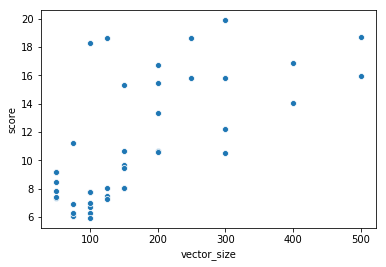

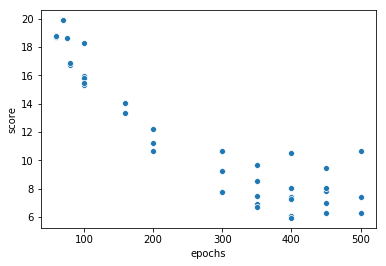

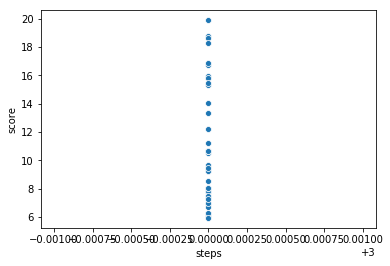

In [143]:
doc_matrix = load_from('../data/processed/doc_matrix.pkl')
vectors = [50, 75, 100, 125, 150]
epochs = [350, 400, 450]
steps = [3]
record, model = grid_search(doc_matrix, vectors, epochs, steps);

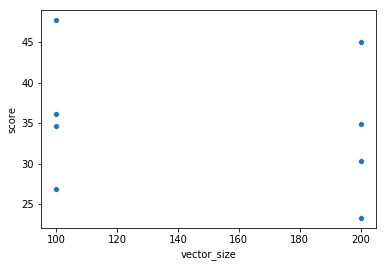

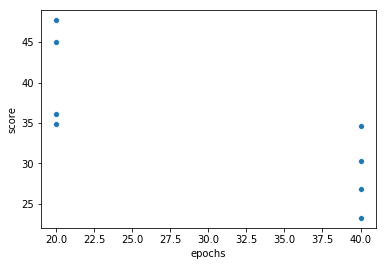

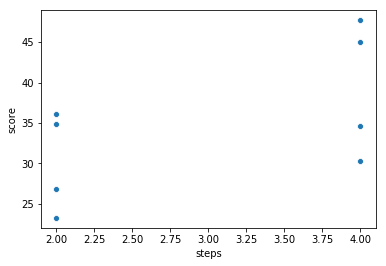

In [91]:
record = get_record()
plot_grid_search(record)

## Model Parameters

In [384]:
vector_size = 125
epochs = 21
steps = 3

In [385]:
model, train_corpus = train_doc2vec(
            doc_matrix, vector_size=125, epochs=21, dm_mean=1)


In [386]:
doc_id = random.randint(0, len(train_corpus) - 1)
model.random.seed(42)
inferred_vector = model.infer_vector(train_corpus[doc_id].words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

for i, sim in enumerate(sims):
    if sim[0] == doc_id:
        print(f'Doc {doc_id}, {doc_matrix.index[doc_id]} was ranked {i} with itself.\n')
        
print('Document ({}): «{}»\n'.format(doc_matrix.index[doc_id], ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)

for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 5)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Doc 272, Hornitos® Margarita was ranked 0 with itself.

Document (Hornitos® Margarita): «hornitos margarita combine all ingredients in shaker strain into margarita glass garnish with lime wedge and serve salt rim optional tequila margarita level easy prep min hawthorne strainer knife margarita glass jigger for smooth tasting tequila made from blue agave look no further than hornitos plata tequila enjoyable start to finish this pure delivery of true agave flavor benefits from hornitos unique cultivation and distillation process with floral and herbal aroma with fruity citrus notes this agave forward tequila has slight citrus note with medium bodied briefly warm and smooth and dry finish savor this expertly crafted tequila on its own or in cocktails like the paloma allowing its clean and fresh character to shine through liquor tequila silver blanco tequila extras mixers syrups bitters syrups sweeteners agave syrup»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d125,n5,w5,mc2,s0.001):



In [398]:
docid = 0
test_str = input()
test_corpus = list(read_corpus([test_str], tokens_only=True))
model.random.seed(42)
inferred_vector = model.infer_vector(test_corpus[0])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

print(u'Most Similar/Dissimilar Cocktails:\n')

for label, index in [('MOST', 0), ('LEAST', len(sims) - 5)]:
    print(f"{label} -- {doc_matrix.index[sims[index][0]]}:\n {' '.join(train_corpus[sims[index][0]].words)}\n")

I want something sweet and smokey, maybe with Mezcal, benedictine, chartreuse and possibly honey? And garnished with a cherry!
want something sweet and smokey maybe with mezcal benedictine chartreuse and possibly honey and garnished with cherry
Most Similar/Dissimilar Cocktails:

MOST -- UV Cran Razzle:
 razzle dazzle your taste buds with this super swift nice and easy incredibly tasty cocktail nbsp uv cran razzle combine ingredients in lowball glass stir and enjoy vodka level easy prep min lowball glass bar spoon jigger enjoy the crisp clean taste of real cranberries straight from the bog it delicious way to get your daily dose of vitamin and unique cranberry health benefits extras soda water soft beverages juice cranberry juice expected is boring which is the opposite of uv blue naturally flavored with vine ripened raspberries uv blue adds touch of sudden sweetness to any situation try it with lemonade lemon lime soda or almost any other mixer liquor vodka flavored vodka
LEAST -- Smi

*Before moving on to exploratory analysis, write down some notes about challenges encountered while working with this data that might be helpful for anyone else (including yourself) who may work through this later on.*

# TF-IDF and LSA Model

*Before you start exploring the data, write out your thought process about what you're looking for and what you expect to find. Take a minute to confirm that your plan actually makes sense.*

*Calculate summary statistics and plot some charts to give you an idea what types of useful relationships might be in your dataset. Use these insights to go back and download additional data or engineer new features if necessary. Not now though... remember we're still just trying to finish the MVP!*

In [259]:
## %%writefile ../src/visualization/visualize.py

# Imports
from itertools import cycle
from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import hvplot.pandas

import nltk
import gensim

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Parameters
int_drink_path = '../data/interim/drink_list.pickle'
doc_matrix_path = '../data/processed/doc_matrix.pkl'
proc_data_path = '../data/processed/dt_matrix.pickle'
vectorizer_path = '../models/vectorizer.pkl'
X_topics_path = '../data/processed/X_topics.pkl'
app_path = '../../speakeasy_app/model/'

# Helper functions go here

# Doc2Vec
# %env PYTHONHASHSEED = 42

# def read_corpus(docs, tokens_only=False):
#     for i, line in enumerate(docs):
#         if tokens_only:
#             yield gensim.utils.simple_preprocess(line)
#         else:
#             # For training data, add tags
#             yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])
            
            
# def train_doc2vec(doc_matrix, vector_size, epochs, dm_mean):
#     train_corpus = list(read_corpus(doc_matrix))

#     model = gensim.models.doc2vec.Doc2Vec(
#         vector_size=vector_size, min_count=2, epochs=epochs, seed=42, workers=1,
#         dm_mean=1)

#     model.build_vocab(train_corpus)
#     model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
#     return model, train_corpus


# def measure_steps(train_corpus, model, s):
#     ranks = []
#     for doc_id in range(len(train_corpus)):
#         inferred_vector = model.infer_vector(train_corpus[doc_id].words, steps=s)
#         sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

#         for i, sim in enumerate(sims):
#             if sim[0] == doc_id:
#                 ranks.append(i + 1)
#     ranks = pd.Series(ranks)
#     score = ranks.mean()
#     return score


# @load_or_make('../models/model_record.pkl', overwrite='n')
# def get_record():
#     cols = ['score', 'vector_size', 'epochs', 'steps']
#     record = pd.DataFrame(columns=cols)
#     return record


# def plot_grid_search(record):
#     for p in ['vector_size', 'epochs', 'steps']:
#         plt.figure()
#         sns.scatterplot(x=p, y='score', data=record[record['score'] < 2]);
#     pass


# def grid_search(doc_matrix, vectors=[125], epochs=[20], steps=[3]):
#     """
#     Performs a grid search to find optimal parameters for doc2vec model.
#     Instantiated with values previously found to be optimal; should be updated
#     if corpus changes significantly.
#     Input:
#         doc_matrix, an array of cleaned documents ready to be tokenized
#         vectors, epochs, and steps are all iterables containing the different
#             parameter permutations to try in the grid search
#     Output: record of all model iterations
#     """
#     record = get_record()
#     for v in vectors:
#         for e in epochs:
#             model, train_corpus = train_doc2vec(
#                 doc_matrix, vector_size=v, epochs=e)
#             for s in steps:
#                 score = measure_steps(train_corpus, model, s)
#                 results = [score, v, e, s]
#                 print(results)
#                 record.loc[len(record)] = results
#     save_to(record, '../models/model_record.pkl')
#     display(record.sort_values(by='score').head(10))
#     plot_grid_search(record)
#     return record

# TF-IDF
def visualize_topics(X, y, suggested):
    tsne = TSNE(n_components=2)
    X_2D = tsne.fit_transform(X)
    
#     print('X TSNE')
    X_2D = pd.DataFrame(X_2D, index=X.index).reset_index()
    X_2D.columns = ['Cocktail', 'Topic 1', 'Topic 2', ]
#     display(X_2D.head())
    
#     print('Y_TSNE')
    y_2D = X_2D[X_2D['Cocktail'] == suggested]

    # Make plot
    p = X_2D.hvplot(x='Topic 1', y='Topic 2', 
                    hover_cols=['Cocktail'], kind='scatter',
                    width=800, height=800) * \
        y_2D.hvplot(x='Topic 1', y='Topic 2', 
                    hover_cols=['Cocktail'], kind='scatter')
    display(p)
    pass
    

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if ix > 4:
            break
        if not topic_names or not topic_names[ix]:
            print("\nCategory ", ix + 1)
        else:
            print("\nCategory: '", topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    pass


def predict(testing=0):
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    vectorizer = load_from(vectorizer_path, verbose=False)
    svd = load_from('../models/svd.pkl', verbose=False)
    X_topics = load_from(X_topics_path, verbose=False)
    
#     display_topics(svd, vectorizer.get_feature_names(), 5)
    
    if testing:
        actual = 'Kamikazi'
#         print(f'***TESTING: This request should yield a "{actual}"')
        print('\nHow would you like your drink?\n')
        request = 'can you make me a bitter manhattan variation with fernet?'
        print(request)
    else:
        request = input('\nHow would you like your drink?\n')
    
    y_doc = clean_document(request)
    y_doc_vec = vectorizer.transform([y_doc])
    y_topic = svd.transform(y_doc_vec)
    
    cosine_sims = cosine_similarity(X_topics, y_topic).flatten()
    cos_sims_sorted = pd.Series(
        cosine_sims, 
        index=X_topics.index,
        name='Cosine Similarity'
    ).sort_values(ascending=False)
    suggested_cocktail = cos_sims_sorted.index[0]

    print('\nMost Similar Cocktails:')
    display(cos_sims_sorted.head())
    
    # TSNE
    visualize_topics(X_topics, y_topic, suggested_cocktail)
    
    return suggested_cocktail


def plot_2D(data, target, target_names):
#     colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()
    pass


def make_exp_var_plot(method):
    exp_var_ratio = method.explained_variance_ratio_
    
    plt.plot(np.cumsum(exp_var_ratio))
    plt.xlabel('# components')
    plt.ylabel('Cumulative explained variance');
    plt.title('Cumulative explained variance by method');
    return


def get_topics(dt_matrix, num_topics):
    
    lsa = TruncatedSVD(num_topics)
    X_topics = lsa.fit_transform(dt_matrix)
    X_topics = pd.DataFrame(X_topics, index=dt_matrix.index)

    save_to(X_topics, X_topics_path, verbose=False)
    save_to(X_topics, app_path + 'X_topics.pkl', verbose=False)
    expl_var = lsa.explained_variance_ratio_
    topic_word = pd.DataFrame(lsa.components_.round(3),
                 columns = dt_matrix.columns)
    return lsa


# @load_or_make(proc_data_path, overwrite='y')
def get_doc_term_matrix(doc_matrix):
    """
    Takes in doc matrix and converts to doc term matrix with TF-IDF vectorier
    """
    vectorizer = TfidfVectorizer(
        strip_accents='unicode',
        stop_words='english',
        ngram_range=(1, 2)
    )
    
    doc_vectors = vectorizer.fit_transform(doc_matrix)
    save_to(vectorizer, vectorizer_path, verbose=False)
    save_to(vectorizer, app_path + 'vectorizer.pkl', verbose=False)
    dt_matrix = pd.DataFrame(
        doc_vectors.toarray(), 
        index=doc_matrix.index, 
        columns=vectorizer.get_feature_names()
    )
    
    return dt_matrix


@load_or_make(doc_matrix_path, overwrite='n')
def get_doc_matrix(drink_list):
    docs = {drink: v['doc'] for drink, v in drink_list.items()}
    doc_matrix = pd.Series(docs)
    
    # Clean up bad data (this should really move to Scrub)
    drop = []
    drop.extend(doc_matrix[doc_matrix.str.contains('<p style=')].index)
    drop.extend(doc_matrix[doc_matrix.str.contains('<w:latentst')].index)
    drop.extend(doc_matrix[doc_matrix == ''].index)
    drop.extend(doc_matrix[doc_matrix.isna()])

    doc_matrix = doc_matrix.drop(index=drop)
    return doc_matrix
    
    
def run(num_components=128):
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    num_components = num_components
    drink_list = load_from(int_drink_path, verbose=False)
    
    save_to(drink_list, app_path + 'drink_list.pkl', verbose=False)
    doc_matrix = get_doc_matrix(drink_list)
    
    #TF-IDF
    dt_matrix = get_doc_term_matrix(doc_matrix)
    svd = get_topics(dt_matrix, num_components)
    save_to(svd, '../models/svd.pkl', verbose=False)
    save_to(svd, app_path + 'svd.pkl', verbose=False)
    drink_prediction = predict(testing=1)
    print(f"I'll make you a {drink_prediction}")
    drink = drink_list[drink_prediction]
    
    recipe = drink['recipe']
    print(f'\nThe recipe for that is:')
    if type(recipe) == list:
        for line in recipe:
            print('\t', line.replace('\n', ' ').replace('\xa0', ' '))
    if type(recipe) == pd.core.frame.DataFrame:
        display(recipe)
    
    print(drink['doc'])
    
    url = drink['url']
    print(f'\nThis cocktail came from:\n{url}')
    
    img_url = drink['img']
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    display(img)
    make_exp_var_plot(svd)
    # data = load_features('data/processed')
    # describe_features(data, 'reports/')
    # generate_charts(data, 'reports/figures/')
    return dt_matrix



How would you like your drink?

can you make me a bitter manhattan variation with fernet?

Most Similar Cocktails:


Apicius                     0.679145
Del Famoso (The Famous)     0.652722
South of Heaven cocktail    0.626704
Schnitzelburg               0.624058
Dr Zeus                     0.615433
Name: Cosine Similarity, dtype: float64

:Overlay
   .Scatter.I  :Scatter   [Topic 1]   (Topic 2,Cocktail)
   .Scatter.II :Scatter   [Topic 1]   (Topic 2,Cocktail)

I'll make you a Apicius

The recipe for that is:


Qty  Units                                   Ingredient
1   1  fl oz                                Rutte Dry Gin
2   ⅓  fl oz   Edmond Briottet Crème de Châtaigne Liqueur
3   ⅓  fl oz  Pierre Ferrand Ancienne Methode Dry Curacao
4   ⅙  fl oz                       Campari Bitter Liqueur
5   ⅙  fl oz       Fernet Branca digestive bitter liqueur

ingredients: rutte dry gin, edmond briottet crème de châtaigne liqueur, pierre ferrand ancienne methode dry curacao, campari bitter liqueur, fernet branca digestive bitter liqueur. name: apicius. glass: serve in a nick & nora glass .... instructions: stir all ingredients with ice and strain into chilled glass.. garnish: none. description: this digestive cocktail is aromatic and bittersweet with herbal and botanical complexity rounded by rich chestnut liqueur.. about: adapted from a drink created in 2017 by sam robertson & alexander taylor at pennyroyal, cardiff, wales. they told us, “apicius is an ancient cookbook which dates back to the 5th century, it provides an insight into the origins of italian cuisine. chestnuts, known to aid digestion, were hugely prominent, combined with amaro this cocktail is the perfect after dinner sipper.”

This cocktail came from:
https://www.diffordsguide.com/cocktails/recipe/4302/apicius


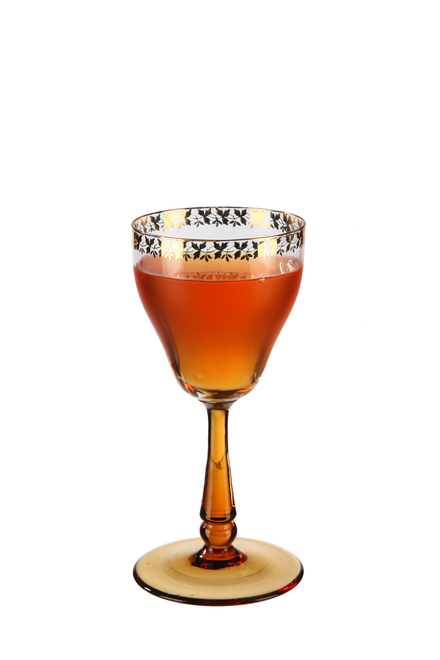

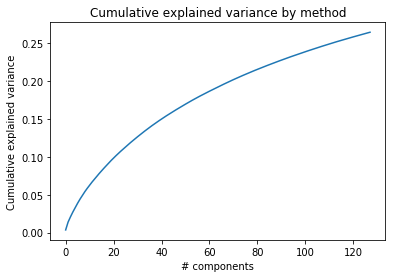

In [260]:
dt_matrix = run()

In [261]:
drink_list = load_from(int_drink_path, verbose=False)
drink = drink_list["'75' Cocktail (Vermeire's 1922 recipe)"]
drink

{'doc': "ingredients: rutte dry gin, berneroy fine calvados, freshly squeezed lemon juice, giffard sirop grenadine (grenadine syrup). name: '75' cocktail (vermeire's 1922 recipe). glass: serve in a coupe glass .... instructions: shake all ingredients with ice and fine strain into chilled glass.. garnish: lemon zest twist. description: spirituous dry and fruity with the botanicals in the gin adding depth of flavour to the other fruity ingredients.. about: adapted from a recipe by henry tépé of henry's bar, paris, france, originally published in robert vermeire’s 1922 book cocktails- how to mix it .",
 'recipe':         Qty  Units                                 Ingredient
 1  1&frac13  fl oz                              Rutte Dry Gin
 2   &frac23  fl oz                     Berneroy Fine Calvados
 3         ⅙  fl oz               Freshly squeezed lemon juice
 4         ¼  fl oz  Giffard Sirop Grenadine (Grenadine Syrup),
 'recipe_html': '<table class="dataframe"> <thead> <tr style="text-

## Tuning Number of Latent Topics

Number of components = 30

How would you like your drink?

can you make me a bitter manhattan variation with fernet?

Most Similar Cocktails:


Enrico Palazzo      0.833335
Kingston Negroni    0.817639
Stazione            0.813438
Via Roma            0.784759
Fifth Degree        0.781305
Name: Cosine Similarity, dtype: float64

:Overlay
   .Scatter.I  :Scatter   [Topic 1]   (Topic 2,Cocktail)
   .Scatter.II :Scatter   [Topic 1]   (Topic 2,Cocktail)

I'll make you a Enrico Palazzo

The recipe for that is:


Qty  Units                             Ingredient
1  1½  fl oz                        Bourbon whiskey
2   1  fl oz           Martini Rosso sweet vermouth
3   ¾  fl oz  Aperol Aperitivo by Fratelli Barbieri
4   ¼  fl oz                   Suze gentian liqueur
5   2   dash   Bittermens Hopped Grapefruit Bitters

ingredients: bourbon whiskey, martini rosso sweet vermouth, aperol aperitivo by fratelli barbieri, suze gentian liqueur, bittermens hopped grapefruit bitters. name: enrico palazzo. glass: serve in a coupe glass .... instructions: stir all ingredients with ice and strain into carbonator. carbonate and pour into chilled glass.. garnish: grapefruit zest twist. description: a bittersweet manhattan-style lightly sparkling cocktail.

This cocktail came from:
https://www.diffordsguide.com/cocktails/recipe/3588/enrico-palazzo


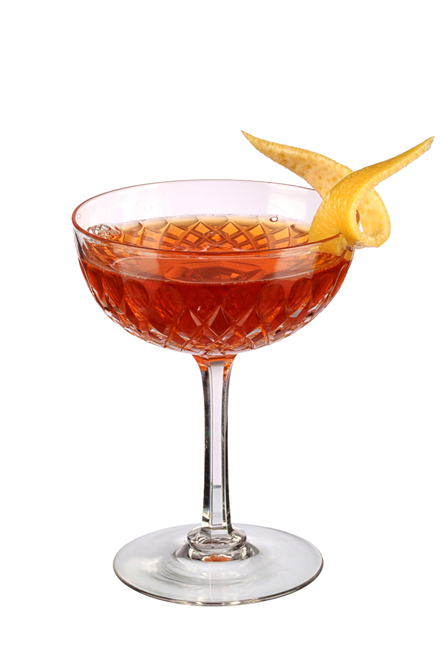

Number of components = 40

How would you like your drink?

can you make me a bitter manhattan variation with fernet?

Most Similar Cocktails:


Enrico Palazzo           0.808514
Kingston Negroni         0.805344
Stazione                 0.788909
Via Roma                 0.768139
Boulevardier Cocktail    0.767650
Name: Cosine Similarity, dtype: float64

:Overlay
   .Scatter.I  :Scatter   [Topic 1]   (Topic 2,Cocktail)
   .Scatter.II :Scatter   [Topic 1]   (Topic 2,Cocktail)

I'll make you a Enrico Palazzo

The recipe for that is:


Qty  Units                             Ingredient
1  1½  fl oz                        Bourbon whiskey
2   1  fl oz           Martini Rosso sweet vermouth
3   ¾  fl oz  Aperol Aperitivo by Fratelli Barbieri
4   ¼  fl oz                   Suze gentian liqueur
5   2   dash   Bittermens Hopped Grapefruit Bitters

ingredients: bourbon whiskey, martini rosso sweet vermouth, aperol aperitivo by fratelli barbieri, suze gentian liqueur, bittermens hopped grapefruit bitters. name: enrico palazzo. glass: serve in a coupe glass .... instructions: stir all ingredients with ice and strain into carbonator. carbonate and pour into chilled glass.. garnish: grapefruit zest twist. description: a bittersweet manhattan-style lightly sparkling cocktail.

This cocktail came from:
https://www.diffordsguide.com/cocktails/recipe/3588/enrico-palazzo


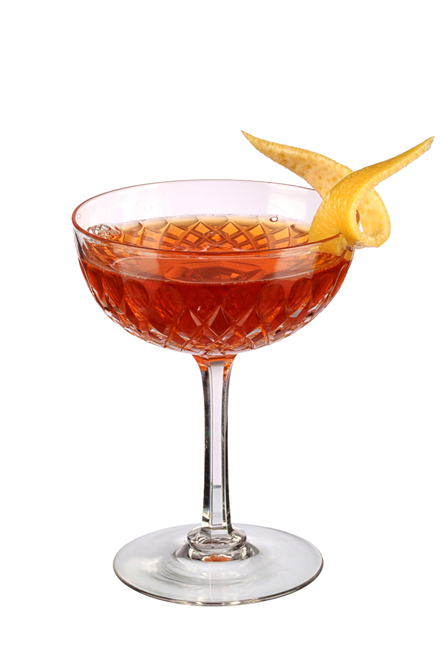

Number of components = 50

How would you like your drink?

can you make me a bitter manhattan variation with fernet?

Most Similar Cocktails:


Kingston Negroni                  0.761696
Boulevardier Cocktail             0.745387
Cornwall Negroni                  0.719968
Stazione                          0.710296
Milano Torino (Mi-To) Cocktail    0.708233
Name: Cosine Similarity, dtype: float64

:Overlay
   .Scatter.I  :Scatter   [Topic 1]   (Topic 2,Cocktail)
   .Scatter.II :Scatter   [Topic 1]   (Topic 2,Cocktail)

I'll make you a Kingston Negroni

The recipe for that is:


Qty  Units                                        Ingredient
1   1  fl oz  Smith & Cross Traditional Pot Still Jamaican Rum
2   1  fl oz                      Martini Rosso sweet vermouth
3   1  fl oz                            Campari Bitter Liqueur

ingredients: smith & cross traditional pot still jamaican rum, martini rosso sweet vermouth, campari bitter liqueur. name: kingston negroni. glass: serve in an old-fashioned glass .... instructions: stir all ingredients with ice and strain into ice-filled glass.. garnish: orange slice. description: the huge character of pungent rum is matched with a bittersweet liqueur and sweet vermouth combo. not for everyone but a negroni riff worth trying.. about: created in 2013 by joaquín simó, new york city, usa

This cocktail came from:
https://www.diffordsguide.com/cocktails/recipe/3475/kingston-negroni


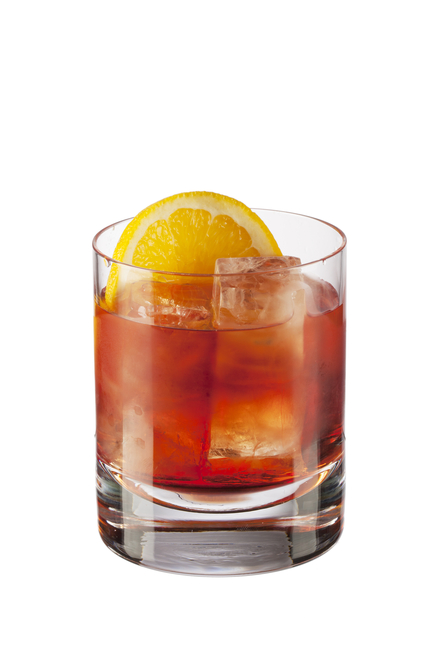

Number of components = 60

How would you like your drink?

can you make me a bitter manhattan variation with fernet?

Most Similar Cocktails:


Cornwall Negroni                  0.715561
Kingston Negroni                  0.705701
Boulevardier Cocktail             0.703086
Milano Torino (Mi-To) Cocktail    0.685421
Negroni Tredici                   0.673022
Name: Cosine Similarity, dtype: float64

:Overlay
   .Scatter.I  :Scatter   [Topic 1]   (Topic 2,Cocktail)
   .Scatter.II :Scatter   [Topic 1]   (Topic 2,Cocktail)

I'll make you a Cornwall Negroni

The recipe for that is:


Qty  Units                    Ingredient
1   2  fl oz                 Rutte Dry Gin
2   ½  fl oz        Campari Bitter Liqueur
3   ½  fl oz           Punt E Mes vermouth
4   ½  fl oz  Martini Rosso sweet vermouth
5   1   dash      Angostura Orange Bitters

ingredients: rutte dry gin, campari bitter liqueur, punt e mes vermouth, martini rosso sweet vermouth, angostura orange bitters. name: cornwall negroni. glass: serve in a coupe glass .... instructions: stir all ingredients with ice and strain into chilled glass.. garnish: orange zest twist (flamed). description: a negroni style cocktail served up. heavy on the gin and relatively light on campari and vermouth. it's a formula that works but like us, you may prefer yours served on the rocks.. about: created in 2006 by philip ward, new york, usa after attending gary 'gaz' regan's cocktails in the country workshop in cornwall-on-hudson.

This cocktail came from:
https://www.diffordsguide.com/cocktails/recipe/2356/cornwall-negroni


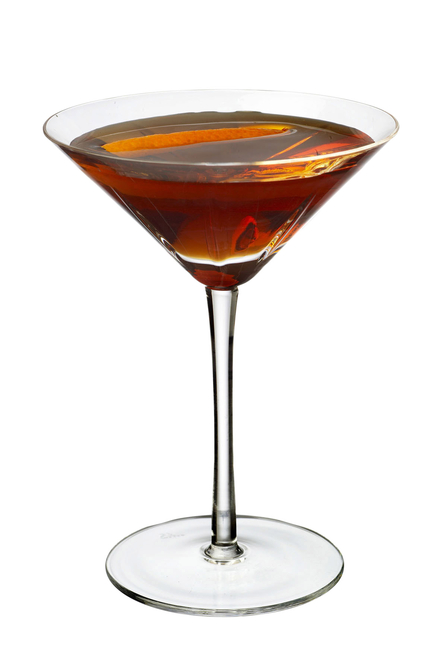

Number of components = 70

How would you like your drink?

can you make me a bitter manhattan variation with fernet?

Most Similar Cocktails:


Stazione                          0.694271
Milano Torino (Mi-To) Cocktail    0.670898
Negroni Tredici                   0.653063
Boulevardier Cocktail             0.651897
Fifth Degree                      0.649055
Name: Cosine Similarity, dtype: float64

:Overlay
   .Scatter.I  :Scatter   [Topic 1]   (Topic 2,Cocktail)
   .Scatter.II :Scatter   [Topic 1]   (Topic 2,Cocktail)

I'll make you a Stazione

The recipe for that is:


Qty  Units                              Ingredient
1   1  fl oz         Liquore Strega Giuseppe Alberti
2   1  fl oz  Fernet Branca digestive bitter liqueur
3   1  fl oz            Martini Rosso sweet vermouth

ingredients: liquore strega giuseppe alberti, fernet branca digestive bitter liqueur, martini rosso sweet vermouth. name: stazione. glass: serve in a nick & nora glass .... instructions: stir all ingredients with ice and strain into chilled glass.. garnish: orange zest twist. description: a spirituous and herbal after dinner digestive.. about: adapted from a recipe by alex frezza. incidentally, stazione is italian for railway station.

This cocktail came from:
https://www.diffordsguide.com/cocktails/recipe/4664/stazione


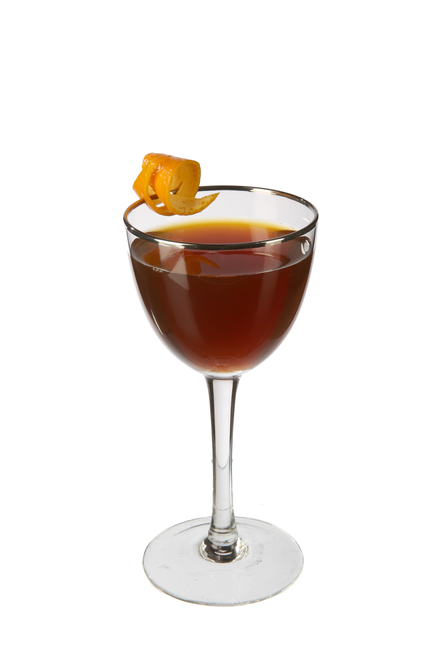

Number of components = 80

How would you like your drink?

can you make me a bitter manhattan variation with fernet?

Most Similar Cocktails:


L'Anniversaire (The Birthday)    0.669682
Apicius                          0.657986
Shakerato                        0.644142
Fifth Degree                     0.638736
Americano                        0.638674
Name: Cosine Similarity, dtype: float64

:Overlay
   .Scatter.I  :Scatter   [Topic 1]   (Topic 2,Cocktail)
   .Scatter.II :Scatter   [Topic 1]   (Topic 2,Cocktail)

I'll make you a L'Anniversaire (The Birthday)

The recipe for that is:


Qty  Units                       Ingredient
1  1&frac23  fl oz                           Cognac
2         ⅓  fl oz                 Drambuie liqueur
3         ⅙  fl oz           Campari Bitter Liqueur
4   &frac23  fl oz  Carpano Antica Formula Vermouth
5         ⅓  fl oz         Raisin sugar syrup (2:1)

ingredients: cognac, drambuie liqueur, campari bitter liqueur, carpano antica formula vermouth, raisin sugar syrup (2:1). name: l'anniversaire (the birthday). glass: serve in a martini glass .... instructions: stir all ingredients with ice and strain into chilled glass.. garnish: orange zest twist. description: rich yet bittersweet with campari providing subtle bitter notes. a good after digestive.. about: created in 2015 by pier schirru at century club, london, england

This cocktail came from:
https://www.diffordsguide.com/cocktails/recipe/3713/lanniversaire-the-birthday


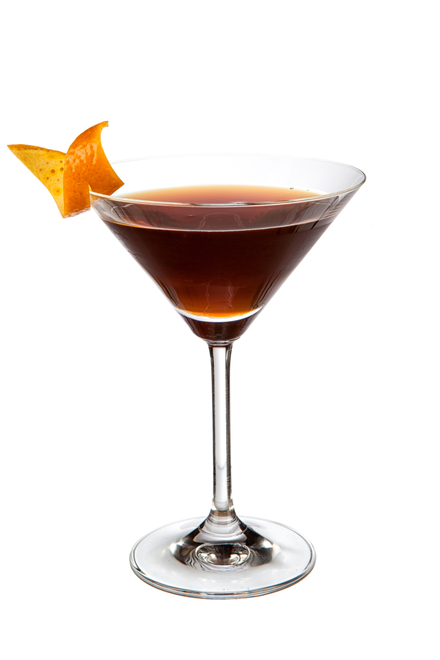

Number of components = 90

How would you like your drink?

can you make me a bitter manhattan variation with fernet?

Most Similar Cocktails:


Stazione                         0.668546
L'Anniversaire (The Birthday)    0.649242
Apicius                          0.646452
Negroni Tredici                  0.612443
Schnitzelburg                    0.610948
Name: Cosine Similarity, dtype: float64

:Overlay
   .Scatter.I  :Scatter   [Topic 1]   (Topic 2,Cocktail)
   .Scatter.II :Scatter   [Topic 1]   (Topic 2,Cocktail)

I'll make you a Stazione

The recipe for that is:


Qty  Units                              Ingredient
1   1  fl oz         Liquore Strega Giuseppe Alberti
2   1  fl oz  Fernet Branca digestive bitter liqueur
3   1  fl oz            Martini Rosso sweet vermouth

ingredients: liquore strega giuseppe alberti, fernet branca digestive bitter liqueur, martini rosso sweet vermouth. name: stazione. glass: serve in a nick & nora glass .... instructions: stir all ingredients with ice and strain into chilled glass.. garnish: orange zest twist. description: a spirituous and herbal after dinner digestive.. about: adapted from a recipe by alex frezza. incidentally, stazione is italian for railway station.

This cocktail came from:
https://www.diffordsguide.com/cocktails/recipe/4664/stazione


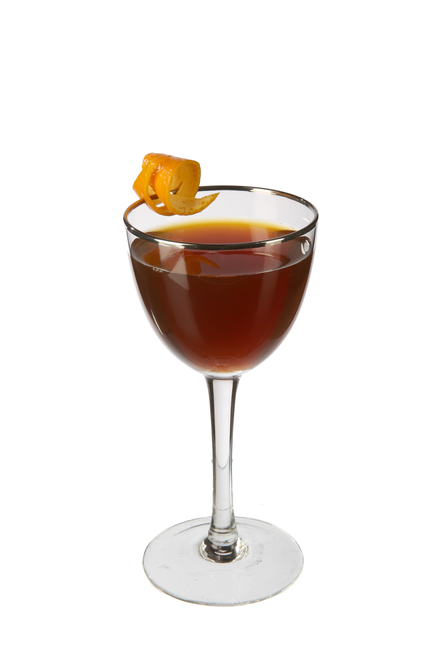

Number of components = 100

How would you like your drink?

can you make me a bitter manhattan variation with fernet?

Most Similar Cocktails:


Apicius                          0.644465
L'Anniversaire (The Birthday)    0.610405
Del Famoso (The Famous)          0.593196
South of Heaven cocktail         0.586130
Schnitzelburg                    0.572278
Name: Cosine Similarity, dtype: float64

:Overlay
   .Scatter.I  :Scatter   [Topic 1]   (Topic 2,Cocktail)
   .Scatter.II :Scatter   [Topic 1]   (Topic 2,Cocktail)

I'll make you a Apicius

The recipe for that is:


Qty  Units                                   Ingredient
1   1  fl oz                                Rutte Dry Gin
2   ⅓  fl oz   Edmond Briottet Crème de Châtaigne Liqueur
3   ⅓  fl oz  Pierre Ferrand Ancienne Methode Dry Curacao
4   ⅙  fl oz                       Campari Bitter Liqueur
5   ⅙  fl oz       Fernet Branca digestive bitter liqueur

ingredients: rutte dry gin, edmond briottet crème de châtaigne liqueur, pierre ferrand ancienne methode dry curacao, campari bitter liqueur, fernet branca digestive bitter liqueur. name: apicius. glass: serve in a nick & nora glass .... instructions: stir all ingredients with ice and strain into chilled glass.. garnish: none. description: this digestive cocktail is aromatic and bittersweet with herbal and botanical complexity rounded by rich chestnut liqueur.. about: adapted from a drink created in 2017 by sam robertson & alexander taylor at pennyroyal, cardiff, wales. they told us, “apicius is an ancient cookbook which dates back to the 5th century, it provides an insight into the origins of italian cuisine. chestnuts, known to aid digestion, were hugely prominent, combined with amaro this cocktail is the perfect after dinner sipper.”

This cocktail came from:
https://www.diffordsguide.com/cocktails/recipe/4302/apicius


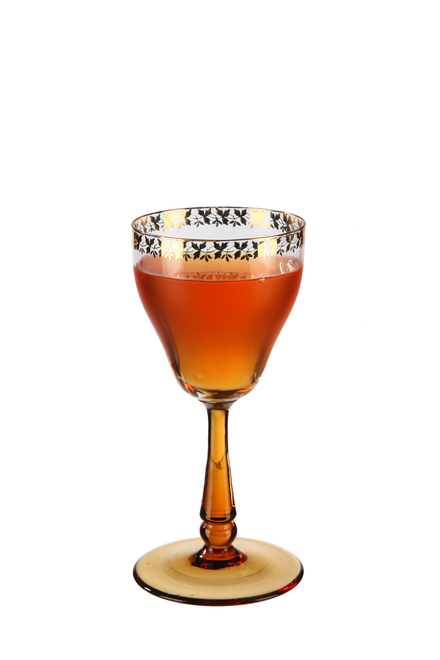

Number of components = 110

How would you like your drink?

can you make me a bitter manhattan variation with fernet?

Most Similar Cocktails:


Apicius                          0.690821
South of Heaven cocktail         0.640550
Del Famoso (The Famous)          0.639568
Schnitzelburg                    0.607106
L'Anniversaire (The Birthday)    0.585486
Name: Cosine Similarity, dtype: float64

:Overlay
   .Scatter.I  :Scatter   [Topic 1]   (Topic 2,Cocktail)
   .Scatter.II :Scatter   [Topic 1]   (Topic 2,Cocktail)

I'll make you a Apicius

The recipe for that is:


Qty  Units                                   Ingredient
1   1  fl oz                                Rutte Dry Gin
2   ⅓  fl oz   Edmond Briottet Crème de Châtaigne Liqueur
3   ⅓  fl oz  Pierre Ferrand Ancienne Methode Dry Curacao
4   ⅙  fl oz                       Campari Bitter Liqueur
5   ⅙  fl oz       Fernet Branca digestive bitter liqueur

ingredients: rutte dry gin, edmond briottet crème de châtaigne liqueur, pierre ferrand ancienne methode dry curacao, campari bitter liqueur, fernet branca digestive bitter liqueur. name: apicius. glass: serve in a nick & nora glass .... instructions: stir all ingredients with ice and strain into chilled glass.. garnish: none. description: this digestive cocktail is aromatic and bittersweet with herbal and botanical complexity rounded by rich chestnut liqueur.. about: adapted from a drink created in 2017 by sam robertson & alexander taylor at pennyroyal, cardiff, wales. they told us, “apicius is an ancient cookbook which dates back to the 5th century, it provides an insight into the origins of italian cuisine. chestnuts, known to aid digestion, were hugely prominent, combined with amaro this cocktail is the perfect after dinner sipper.”

This cocktail came from:
https://www.diffordsguide.com/cocktails/recipe/4302/apicius


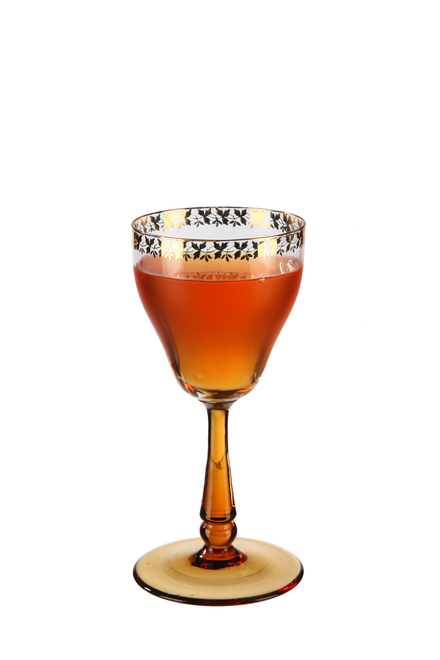

Number of components = 120

How would you like your drink?

can you make me a bitter manhattan variation with fernet?

Most Similar Cocktails:


Apicius                     0.689041
Del Famoso (The Famous)     0.673019
South of Heaven cocktail    0.658533
Schnitzelburg               0.643186
Dr Zeus                     0.618864
Name: Cosine Similarity, dtype: float64

:Overlay
   .Scatter.I  :Scatter   [Topic 1]   (Topic 2,Cocktail)
   .Scatter.II :Scatter   [Topic 1]   (Topic 2,Cocktail)

I'll make you a Apicius

The recipe for that is:


Qty  Units                                   Ingredient
1   1  fl oz                                Rutte Dry Gin
2   ⅓  fl oz   Edmond Briottet Crème de Châtaigne Liqueur
3   ⅓  fl oz  Pierre Ferrand Ancienne Methode Dry Curacao
4   ⅙  fl oz                       Campari Bitter Liqueur
5   ⅙  fl oz       Fernet Branca digestive bitter liqueur

ingredients: rutte dry gin, edmond briottet crème de châtaigne liqueur, pierre ferrand ancienne methode dry curacao, campari bitter liqueur, fernet branca digestive bitter liqueur. name: apicius. glass: serve in a nick & nora glass .... instructions: stir all ingredients with ice and strain into chilled glass.. garnish: none. description: this digestive cocktail is aromatic and bittersweet with herbal and botanical complexity rounded by rich chestnut liqueur.. about: adapted from a drink created in 2017 by sam robertson & alexander taylor at pennyroyal, cardiff, wales. they told us, “apicius is an ancient cookbook which dates back to the 5th century, it provides an insight into the origins of italian cuisine. chestnuts, known to aid digestion, were hugely prominent, combined with amaro this cocktail is the perfect after dinner sipper.”

This cocktail came from:
https://www.diffordsguide.com/cocktails/recipe/4302/apicius


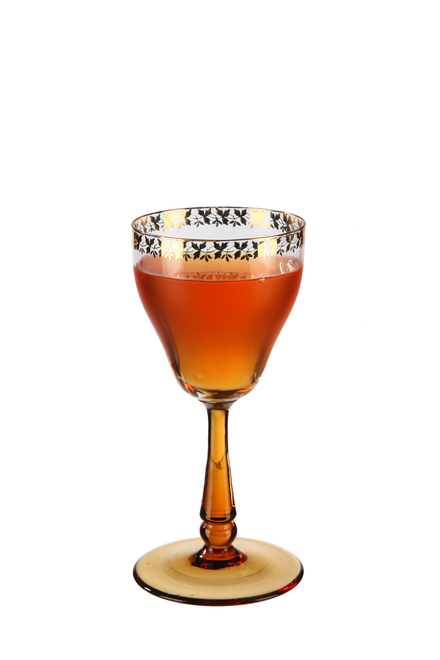

Number of components = 130

How would you like your drink?

can you make me a bitter manhattan variation with fernet?

Most Similar Cocktails:


Del Famoso (The Famous)     0.699197
Apicius                     0.673331
South of Heaven cocktail    0.668430
Dr Zeus                     0.661799
Schnitzelburg               0.657916
Name: Cosine Similarity, dtype: float64

:Overlay
   .Scatter.I  :Scatter   [Topic 1]   (Topic 2,Cocktail)
   .Scatter.II :Scatter   [Topic 1]   (Topic 2,Cocktail)

I'll make you a Del Famoso (The Famous)

The recipe for that is:


Qty  Units                                         Ingredient
1  1½  fl oz  Patrón Silver Tequila (green seal) 100% agave ...
2   ¾  fl oz             Fernet Branca digestive bitter liqueur
3   ½  fl oz                    Carpano Antica Formula Vermouth
4   ½  fl oz    Giffard Sugar Cane Syrup (Sirop Sucre de Canne)
5   2   dash                         Angostura Aromatic Bitters

ingredients: patrón silver tequila (green seal) 100% agave tequila, fernet branca digestive bitter liqueur, carpano antica formula vermouth, giffard sugar cane syrup (sirop sucre de canne), angostura aromatic bitters. name: del famoso (the famous). glass: serve in a coupe glass .... instructions: stir all ingredients with ice and strain into chilled glass.. garnish: none. description: the herbal spicy peppermint and liquorice notes of fernet branca dominate this digestive-style tequila laced cocktail.. about: adapted from a recipe created in june 2017 by nathan hinze at 99 hanover street, edinburgh, scotland. the cocktail’s name is inspired by the wording on the fernet branca label.

This cocktail came from:
https://www.diffordsguide.com/cocktails/recipe/4379/del-famoso-the-famous


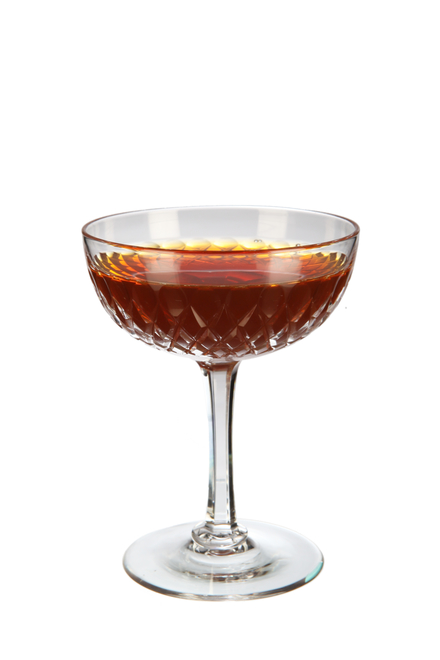

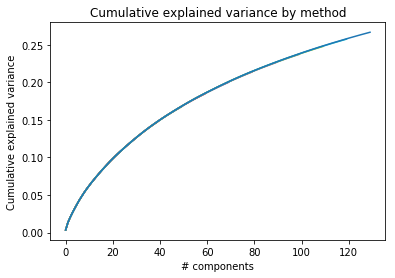

In [161]:
for n in range(30, 131, 10):
    print(f'Number of components = {n}')
    dt_matrix = run(num_components=n)


*What did you learn? What relationships do you think will be most helpful as you build your model?*

# Universal Helpers

In [166]:
import os
import pickle

def load_or_make(filepath, overwrite='n'):
    def decorator(func):
        def wraps(*args, **kwargs):
            if overwrite == 'y':
                ow = input(f'Are you sure you want to overwrite {filepath}? y/n: ')
                if (os.path.exists(filepath)) and (ow == 'y'):
                    os.remove(filepath)
            try:
                with open(filepath, 'rb') as f:
                    data = pickle.load(f)
            except:
                data = func(*args, **kwargs)
                with open(filepath, 'wb') as to_write:
                    pickle.dump(data, to_write)
            return data
        return wraps
    return decorator


def save_to(item, filepath, verbose=True):
    """
    Pickles item sand saves it to path
    Input: object to be pickled, string containing directory and filename
    Output: pickled object stored to provided path
    """
    with open(filepath, 'wb') as to_write:
        pickle.dump(item, to_write, protocol=2)
    if verbose:
        print(f'Saved file to {filepath}')
    return


def load_from(filepath, verbose=True):
    """
    Unpickles item and returns item from path
    Input: filepath to pickled object
    Output: unpickled object
    """
    if not file_exists(filepath):
        print(f'Failed to load from {filepath}. Does not exist.')
    with open(filepath, 'rb') as f:
        item = pickle.load(f)
    if verbose:
        print(f'Loaded file from {filepath}')
    return item


def file_exists(filepath):
    """
    Returns True if specified file already exists, else False
    Input:
        path (str), path to directory containing file
        filename (str), name of file to check for
    Output: True if specified file already exists, else False
    """
    file_exists = os.path.isfile(filepath)
    return file_exists

